# #everystreetchallenge algorithm
Over the COVID-19 lockdown many runners / cyclist found themselves captured within their cities. Some of them ended up running / spinning endless hours on virtual races such as Zwift, but some as e.g. [Mark Beaumont](https://www.strava.com/athletes/8288853) [1] decided to join #everystreetchallenge. Every street is a challenge originated by [Rickey Gates](https://www.everysinglestreet.com/why) [2, 3] (?) who run *every single street* in city of San Francisco in fall 2018 which took him 46 days and run 1,303 miles.

Inspired by Mark Beaumont who did this challenge over the lockdown in Edinburgh, place where I spend the lockdown, and literally everybody else who managed to accomplish this challenge. (*I would have never had the patience and motivation to run that much in the city*) I said to myself that I am more mathematician than a runner or cyclist. So, I ask myself, what is the optimal route? is there any algorithm that can generate the route?

## Chinese postman problem
Finding a route for #everystreetchallenge is basically the well-known problem of *chinese postman*, called after Chinese mathematician Kuan Mei-Ko. (Also known as *Postman Tour* or *Route Inspection Problem*) The problem is to find the shortest closed path (or circuit) such that visits every edge of a (closed and undirected) graph. 

This solution is strongly inspired algorithm by Ruslan Zabrodin [6] and Andrew Brooks blog post [5]. For implementing the solution we used `Networkx` [7], `osmnx` a python package which uses OpenStreetMap's API [8] and my tiny network package [9].

In [1]:
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)
from tools import *
from graph_route import plot_graph_route
import matplotlib.pyplot as plt
from network import Network
from network.algorithms import hierholzer

We used `osmnx` a source to fetch and plot geographical data. As an example we choose an Edinburgh neighborhood of the Grange.  

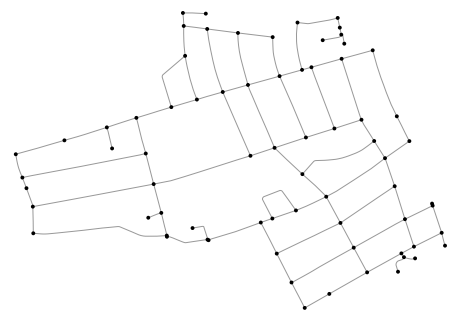

In [2]:
location = 'The Grange, Edinburgh, Scotland'
org_graph = ox.graph_from_place(location, network_type='drive')
graph = ox.utils_graph.get_undirected(org_graph)  # for simplification we can use undirected graph
fig, ax = ox.plot_graph(graph, node_zorder=2, node_color='k', bgcolor='w')

###  Algorithm
In this work, we used algorithm mentioned by Ruslan Zabrodin [6], which states as follow: 
1. Get nodes with odd degree
2. Count distance between all odd-degree nodes
3. Create a complete weighted graph of all odd-degree nodes, as weights we use distance from 2.
4. Count minimal matching in the complete weighted graph (or maximal matching with inverted weights `-w`)
5. Add matched pairs into original graph
6. Find the Eulerian circuit using Hierholzer [10] algorithm
7. Sanitize *Eulerian circuit* such that if edge of *matched pair* doesn't exists find closed path connecting *matched pair*

In [3]:
odd_degree_nodes = get_odd_degree_nodes(graph)
pair_weights = get_shortest_distance_for_odd_degrees(graph, odd_degree_nodes)
matched_edges_with_weights = max_matching(pair_weights)
single_edges = get_single_edges(graph)

Result of *minimal matching* plotted into original graph (red edges).

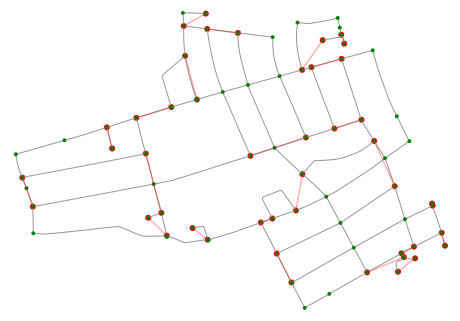

In [4]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='black', frameon=False)
for v, u, w in matched_edges_with_weights:
    x = graph.nodes[v]["x"], graph.nodes[u]["x"]
    y = graph.nodes[v]["y"], graph.nodes[u]["y"]
    ax.plot(x, y, c='red', alpha=0.3)
    ax.scatter(x, y, c='red', edgecolor="none")

fig, ax = ox.plot_graph(graph, node_zorder=2, node_color='g', bgcolor='k', ax=ax)

Counting the `final_path` with Hierholzer algorithm and plotting on map. As we can see all edges were visited.

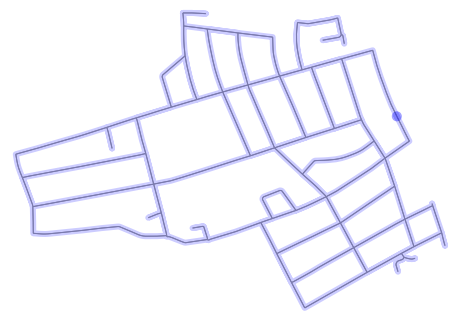

In [5]:
edges = map_osmnx_edges2integers(graph, single_edges + matched_edges_with_weights)

network = Network(len(graph.nodes), edges, weighted=True)
eulerian_path = hierholzer(network)
converted_eulerian_path = convert_integer_path2osmnx_nodes(eulerian_path, graph.nodes())
double_edge_heap = get_double_edge_heap(graph)

final_path = convert_path(graph, converted_eulerian_path, double_edge_heap)
fig, ax = plot_graph_route(org_graph, final_path, route_linewidth=6, node_size=0, bgcolor='w', route_alpha=0.2, route_color='b')

In order to see how the *runner* should accomplish the route on the map, we created a simple GIF.

In [6]:
for i, e in enumerate(final_path, start=1):
    fig, ax = plot_graph_route(org_graph, final_path[:i], route_linewidth=6, node_size=0, bgcolor='w', route_alpha=0.2)
    ax.set_title(location)
    fig.savefig(f'img_{i}.png', dpi=120, bbox_inches='tight')

![](everystree_grange.gif)

## Conclusion
In this work, we tried to adapt the *Postman Tour Problem* to the #everystreetchallenge. Using `OSMnx` package we were able to demonstrate on real data. 

### Addition
As an addition to previous work we managed to implement the problem on Open Street Map which is a real map represented as directed and weighted multigraph, while previous works [5] could not manage multi-edges.

### Limitation
The biggest limitation of this work is the speed and performance of the algorithm. However *Postman Tour Problem* is not NP hard problem we are dealing algorithms such as Hierholzer's algorithm $O(|E|)$, Dijkstra's algorithm $\Theta(|E| + |V|log(|V|))$ and Weighted maximum matching having $O(|V|^3) [11, 12]$. In addition Python packages `NetworkX` and `OSMnx` are simply not the fastest :)

## Related readings
 - Brooks Andrew, 2018, "Graph optimization solvers for the Postman Problems", https://github.com/brooksandrew/postman_problems
 - Wen LeaPearn1, C.M.Liu2, 1994, "Algorithms for the Chinese postman problem on mixed networks", https://kundoc.com/pdf-algorithms-for-the-chinese-postman-problem-on-mixed-networks-.html

## References
 - [1] Mark Beaumont Strava Profile, https://www.strava.com/athletes/8288853  
 - [2] Rickey Hates (2019), Every Single Street with Rickey Hates, https://www.everysinglestreet.com/why
 - [3] Katherine Turner (2019), Every Single Street,  Strava stories, https://blog.strava.com/every-single-street-17484/ 
 - [4] Reinhard Diestel (2000), Graph Theory, Springer, Volume 173 of Graduate texts in mathematics, ISSN 0072-5285  
 - [5] Andrew Brooks (2017), Intro to graph optimization: solving the Chinese Postman Problem, http://brooksandrew.github.io/simpleblog/articles/intro-to-graph-optimization-solving-cpp/  
 - [6] Ruslan Zabrodin (2015), Postman Problem, https://www-m9.ma.tum.de/graph-algorithms/directed-chinese-postman/index_en.html
 - [7] NetworkX Developers (2020), "NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.", https://github.com/networkx/networkx
 - [8] Boeing, G. (2017). "OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks." Computers, Environment and Urban Systems 65, 126-139. doi:10.1016/j.compenvurbsys.2017.05.004
 - [9] Matej Kerekrety (2020), "Simple pure Python package for generating, modifying and playing with (even complex) networks.", https://github.com/matejker/network
 - [10] Ruslan Zabrodin (2015), Algorithmus von  Hierholzer, https://www-m9.ma.tum.de/graph-algorithms/hierholzer/index_en.html
 - [11] Galil, Z. (1986). Efficient algorithms for finding maximum matching in graphs. ACM Comput. Surv., 18, 23-38.https://www.semanticscholar.org/paper/Efficient-algorithms-for-finding-maximum-matching-Galil/ef1b31b4728615a52e3b8084379a4897b8e526ea?p2df
 - [12] Jack Edmonds (2008), "Weighted maximum matching in general graphs.", http://jorisvr.nl/files/graphmatching/20130407/mwmatching.py